# Rare Disease Subtyping (ALS)

## Initialize Varibales and Libraries

In [2]:
import os 
print("Current working directory:", os.getcwd())
print("\nFiles in this directory:")
print(os.listdir())

Current working directory: /Users/chanteralazard/Downloads/rare_disease_pipeline

Files in this directory:
['output_nvflare_kmeans_1', '__pycache__', 'total_pipeline-2.ipynb', 'fed_kmeans_components.py', 'clients_data', 'main.py', 'synthetic_patients.csv']


In [3]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, silhouette_score

INPUT_CSV = "synthetic_patients.csv"
OUT_DIR = "clients_data"  # will create one csv per superpopulation
SUPERPOP_COL = "superpopulation"

drop_cols = {
    "patient_id",
    "superpopulation",
    "n_variants_carried",
    "primary_gene",
    "primary_condition",
    "primary_subtype",
    "onset_type",
    "base_impact",
    "allelic_ratio",
    "ancestral_modifier",
    "modifier_type",
    "consequence_modifier",
    "interaction_score",
    "predicted_progression",
    "all_genes",
    "all_subtypes",
}

## Data prep (split by ancestry clients, assuming data was collected by a separate client)

In [4]:
df = pd.read_csv(INPUT_CSV)

os.makedirs(OUT_DIR, exist_ok=True)
for sp, g in df.groupby(SUPERPOP_COL):
    out = os.path.join(OUT_DIR, f"client_{sp}.csv")
    g.to_csv(out, index=False)
    print("wrote", out, ", rows:", len(g))

wrote clients_data/client_AFR.csv , rows: 3000
wrote clients_data/client_AMR.csv , rows: 3000
wrote clients_data/client_EAS.csv , rows: 3000
wrote clients_data/client_EUR.csv , rows: 3000
wrote clients_data/client_SAS.csv , rows: 3000


## Calculate Silhouette Score and WCSS

In [5]:
import sys
print(sys.version)

3.12.12 | packaged by conda-forge | (main, Oct 22 2025, 23:34:53) [Clang 19.1.7 ]


In [13]:
!pip install nvflare

1442.04s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Running k=1...
2026-01-14 07:33:54,228 - INFO - Initializing ScatterAndGather workflow for Federated Averaging.
2026-01-14 07:33:54,228 - INFO - Beginning ScatterAndGather training phase.
2026-01-14 07:33:54,228 - INFO - Round 0 started.
2026-01-14 07:33:58,127 - INFO - Contribution from SAS ACCEPTED by the aggregator at round 0.
2026-01-14 07:33:58,142 - INFO - Contribution from EAS ACCEPTED by the aggregator at round 0.
2026-01-14 07:33:58,156 - INFO - Contribution from AMR ACCEPTED by the aggregator at round 0.
2026-01-14 07:33:58,168 - INFO - Contribution from AFR ACCEPTED by the aggregator at round 0.
2026-01-14 07:33:58,178 - INFO - Contribution from EUR ACCEPTED by the aggregator at round 0.
2026-01-14 07:33:58,346 - INFO - Start aggregation.
round 00 inertia 431631.12 moved 20.9325 counts [15000]
2026-01-14 07:33:58,347 - INFO - End aggregation.
2026-01-14 07:33:58,348 - INFO - Round 0 finished.
2026-01-14 07:33:58,366 - INFO - Round 1 started.
2026-01-14 07:34:00,187 - INFO - 

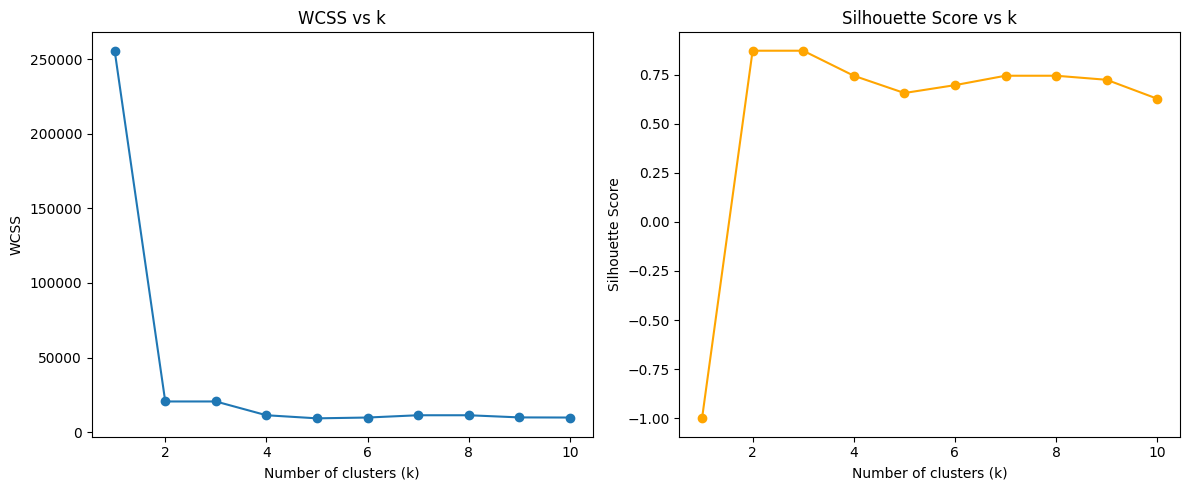

In [6]:
ws = []
sils = []
for i in range(1, 11):
    print(f"Running k={i}...")
    !python "main.py" --k {i} --workspace output_nvflare_kmeans_{i}

    metrics_paths = glob.glob(f"output_nvflare_kmeans_{i}/**/kmeans_metrics.csv", recursive=True)
    centers_paths = glob.glob(f"output_nvflare_kmeans_{i}/**/final_centers.npy", recursive=True)

    metrics_path = sorted(metrics_paths)[-1]
    centers_path = sorted(centers_paths)[-1]

    m = pd.read_csv(metrics_path)
    centers = np.load(centers_path)

    # load pooled data
    df = pd.read_csv(INPUT_CSV)
    feat_cols = [c for c in df.columns if c not in drop_cols]
    X = df[feat_cols].to_numpy(dtype=np.float32)

    Xs = X
    Cs = centers
    
    d2 = ((Xs[:, None, :] - Cs[None, :, :]) ** 2).sum(axis=2)
    labels = d2.argmin(axis=1)

    # compute WCSS (Within-Cluster Sum of Squares)
    wcss = 0.0
    for k in range(Cs.shape[0]):
        cluster_points = Xs[labels == k]
        wcss += ((cluster_points - Cs[k]) ** 2).sum()
    ws.append((i, wcss))
    
    # compute silhouette score
    n = Xs.shape[0]
    try:
        sil = silhouette_score(Xs, labels, metric="euclidean")
    except:
        sil = -1.0
    sils.append((i, sil))
    
print("k and sil vs WCSS:")
ws = np.array(ws)
sils = np.array(sils)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(ws[:, 0], ws[:, 1], marker='o')
plt.title("WCSS vs k")
plt.xlabel("Number of clusters (k)")
plt.ylabel("WCSS")
plt.subplot(1, 2, 2)
plt.plot(sils[:, 0], sils[:, 1], marker='o', color='orange')
plt.title("Silhouette Score vs k")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.tight_layout()
plt.show()


## Calculate Optimal k

In [8]:
min_val = min(ws[:, 1])
k = [i for i, x in enumerate(ws[:, 1]) if x == min_val][0] + 1
print("Optimal k (min WCSS):", k)

Optimal k (min WCSS): 5


In [10]:
print("Silhouette score of optimal k:", round(sils[k-1, 1], 2))

Silhouette score of optimal k: 0.66


## Bootstrap stability for clustering
- answers: do we get the same clustering if we resample patients and rerun k means from the same initialization?

In [11]:
def bootstrap_stability(X, base_labels, k, init_centers, B=50, seed=0):
    rng = np.random.default_rng(seed)
    n = X.shape[0]
    scores = []
    for b in range(B):
        idx = rng.integers(0, n, size=n)  # bootstrap sample indices
        Xb = X[idx]

        km = KMeans(
            n_clusters=k,
            init=init_centers,
            n_init=1,
            max_iter=100,
            random_state=seed + b,
        ).fit(Xb)

        # predict labels on full X using bootstrapped centers
        Cb = km.cluster_centers_.astype(np.float32)
        d2 = ((X[:, None, :] - Cb[None, :, :]) ** 2).sum(axis=2)
        pred = d2.argmin(axis=1)

        scores.append(adjusted_rand_score(base_labels, pred))
    return np.array(scores)

metrics_paths = glob.glob(f"output_nvflare_kmeans_{k}/**/kmeans_metrics.csv", recursive=True)
centers_paths = glob.glob(f"output_nvflare_kmeans_{k}/**/final_centers.npy", recursive=True)

metrics_path = sorted(metrics_paths)[-1]
centers_path = sorted(centers_paths)[-1]

m = pd.read_csv(metrics_path)
centers = np.load(centers_path)

# load pooled data
df = pd.read_csv(INPUT_CSV)
feat_cols = [c for c in df.columns if c not in drop_cols]
X = df[feat_cols].to_numpy(dtype=np.float32)

Xs = X
Cs = centers

d2 = ((Xs[:, None, :] - Cs[None, :, :]) ** 2).sum(axis=2)
labels = d2.argmin(axis=1)

st = bootstrap_stability(Xs, labels, k=centers.shape[0], init_centers=centers, B=50, seed=7)
print("ARI mean", st.mean(), "std", st.std(), "min", st.min(), "max", st.max())

ARI mean 1.0 std 0.0 min 1.0 max 1.0


# Visualization

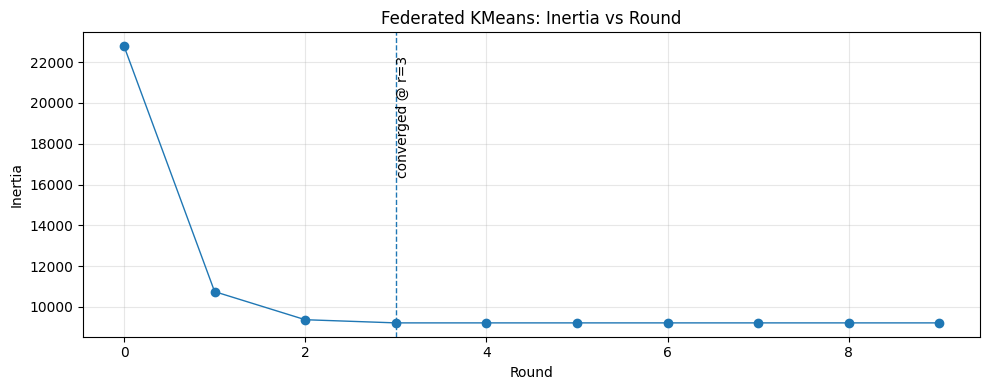

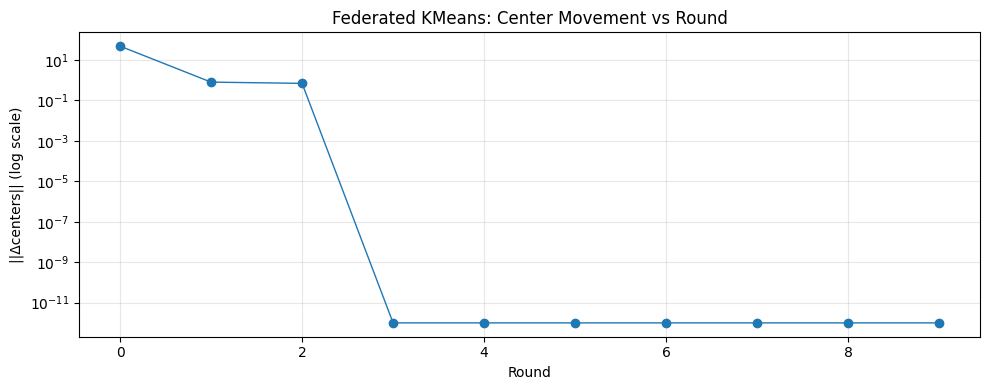

Converged round: 3
Final inertia: 9219.8017578125
Final counts: {'count_0': 287, 'count_1': 3287, 'count_2': 1999, 'count_3': 8582, 'count_4': 845}
Dead clusters: []


In [12]:
csv_path = glob.glob(f"output_nvflare_kmeans_{k}/**/kmeans_metrics.csv", recursive=True)
m = pd.read_csv(csv_path[-1]).sort_values("round").reset_index(drop=True)

rounds = m["round"].to_numpy()
inertia = m["inertia"].to_numpy()
moved = m["moved"].to_numpy()

count_cols = [c for c in m.columns if c.startswith("count_")]
counts = m[count_cols].to_numpy()
total = counts.sum(axis=1)
props = counts / total[:, None]

# find convergence round: first round where moved == 0 and stays 0
conv_r = None
for i in range(len(rounds)):
    if moved[i] == 0 and np.all(moved[i:] == 0):
        conv_r = int(rounds[i])
        break

# Inertia with improvement annotations
plt.figure(figsize=(10,4))
plt.plot(rounds, inertia, marker="o", linewidth=1)
plt.grid(True, alpha=0.3)
plt.xlabel("Round")
plt.ylabel("Inertia")
plt.title("Federated KMeans: Inertia vs Round")
if conv_r is not None:
    plt.axvline(conv_r, linestyle="--", linewidth=1)
    plt.text(conv_r, inertia.max()*0.98, f"converged @ r={conv_r}", rotation=90, va="top")
plt.tight_layout()
plt.show()

# Movement (log scale helps when it quickly goes to 0)
eps = 1e-12
plt.figure(figsize=(10,4))
plt.plot(rounds, moved + eps, marker="o", linewidth=1)
plt.yscale("log")
plt.grid(True, alpha=0.3)
plt.xlabel("Round")
plt.ylabel("||Δcenters|| (log scale)")
plt.title("Federated KMeans: Center Movement vs Round")
plt.tight_layout()
plt.show()

# summary
final_counts = dict(zip(count_cols, counts[-1].tolist()))
dead = [c for c, v in final_counts.items() if v == 0]

print("Converged round:", conv_r)
print("Final inertia:", float(inertia[-1]))
print("Final counts:", final_counts)
print("Dead clusters:", dead)

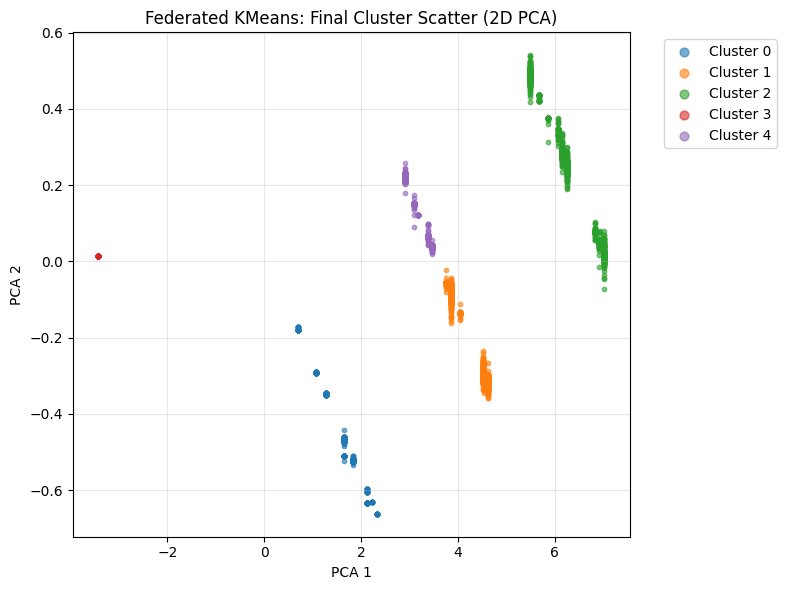

In [13]:
# Reduce to 2D for plotting
pca = PCA(n_components=2, random_state=0)
X_2d = pca.fit_transform(Xs)

# Scatter plot
plt.figure(figsize=(8,6))
num_clusters = centers.shape[0]
for i in range(num_clusters):
    cluster_points = X_2d[labels == i]
    if cluster_points.shape[0] > 0:
        plt.scatter(cluster_points[:,0], cluster_points[:,1], label=f"Cluster {i}", s=10, alpha=0.6)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Federated KMeans: Final Cluster Scatter (2D PCA)")
plt.legend(markerscale=2, bbox_to_anchor=(1.05, 1))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# CONFIG
OUTPUT_DIR = "output_nvflare_kmeans"

df = pd.read_csv(INPUT_CSV)

genes = df["primary_gene"]

drop_cols = {
    "patient_id", "superpopulation", "n_variants_carried",
    "primary_gene", "primary_condition", "primary_subtype",
    "onset_type", "base_impact", "allelic_ratio",
    "ancestral_modifier", "modifier_type",
    "consequence_modifier", "interaction_score",
    "predicted_progression", "all_genes", "all_subtypes"
}

feat_cols = [c for c in df.columns if c not in drop_cols]
X = df[feat_cols].to_numpy(dtype=np.float32)

Xs = X
Cs = centers

# Assign clusters
d2 = ((Xs[:, None, :] - Cs[None, :, :]) ** 2).sum(axis=2)
labels = d2.argmin(axis=1)

# Primary_gene → cluster mapping
cluster_df = pd.DataFrame({
    "primary_gene": genes,
    "cluster": labels
})

# counts per (cluster, gene)
gene_cluster_counts = (
    cluster_df
    .value_counts(["cluster", "primary_gene"])
    .rename("count")
    .reset_index()
    .sort_values(["cluster", "count"], ascending=[True, False])
)

# Save outputs
gene_cluster_counts.to_csv("primary_gene_by_cluster_counts.csv", index=False)

print("Saved: primary_gene_by_cluster_counts.csv")

Saved: primary_gene_by_cluster_counts.csv


In [16]:
# CONFIG
OUTPUT_DIR = "output_nvflare_kmeans"
df = pd.read_csv(INPUT_CSV)
genes = df["primary_gene"]
drop_cols = {
    "patient_id", "superpopulation", "n_variants_carried",
    "primary_gene", "primary_condition", "primary_subtype",
    "onset_type", "base_impact", "allelic_ratio",
    "ancestral_modifier", "modifier_type",
    "consequence_modifier", "interaction_score",
    "predicted_progression", "all_genes", "all_subtypes"
}
feat_cols = [c for c in df.columns if c not in drop_cols]
X = df[feat_cols].to_numpy(dtype=np.float32)
Xs = X
Cs = centers

# Assign clusters
d2 = ((Xs[:, None, :] - Cs[None, :, :]) ** 2).sum(axis=2)
labels = d2.argmin(axis=1)

# Primary_gene → cluster mapping
cluster_df = pd.DataFrame({
    "primary_gene": genes,
    "cluster": labels
})

# counts per (cluster, gene)
gene_cluster_counts = (
    cluster_df
    .value_counts(["cluster", "primary_gene"])
    .rename("count")
    .reset_index()
    .sort_values(["cluster", "count"], ascending=[True, False])
)

# Save single output
gene_cluster_counts.to_csv("gene_cluster_counts.csv", index=False)
print("Saved: gene_cluster_counts.csv")
print(f"\nTotal rows: {len(gene_cluster_counts)}")
print("\nPreview:")
print(gene_cluster_counts.head(20))


Saved: gene_cluster_counts.csv

Total rows: 66

Preview:
    cluster  primary_gene  count
10        0          SETX    136
13        0          ALS2    105
36        0       SIGMAR1     23
47        0         ERBB4     16
57        0       PLEKHG5      7
0         1          SOD1   1485
2         1          ALS2    413
3         1         SPG11    379
5         1           VCP    275
9         1        TARDBP    155
12        1        UBQLN2    119
18        1         DCTN1     71
21        1          TBK1     61
22        1        SPTLC1     58
23        1          OPTN     57
25        1       SIGMAR1     45
26        1          FIG4     42
32        1        SQSTM1     34
38        1  LOC124629354     23
42        1        CHMP2B     21


In [20]:
# Add cluster labels to original dataframe
df['cluster'] = labels

# Test 1: Severity Score by Cluster
print("=" * 60)
print("SEVERITY SCORE BY CLUSTER")
print("=" * 60)
severity_by_cluster = df.groupby('cluster')['severity_score'].describe()
print(severity_by_cluster)
print("\n")

SEVERITY SCORE BY CLUSTER
          count      mean       std  min  25%  50%   75%   max
cluster                                                       
0         287.0  4.997909  0.439877  4.0  5.0  5.0   5.2   5.7
1        3287.0  7.269547  0.348146  6.9  7.0  7.0   7.7   7.8
2        1999.0  9.299300  0.596108  8.4  9.0  9.2  10.0  10.0
3        8582.0  0.000000  0.000000  0.0  0.0  0.0   0.0   0.0
4         845.0  6.320710  0.244192  6.0  6.0  6.5   6.5   6.6




- Per the Severity Score by Cluster, it does appear that we are seeing a severity gradient and therefore it might be clustering by severity and not subtypes. 
- Cluster 3 = Control (severity = 0)
- Rank of Severity based on means
- - C0: 5.00 (Mild)
- - C4: 6.32 (Moderate)
- - C1: 7.27 (Moderately Severe: Classic Case) 
- - C2: 9.30 (Severe)
- This is showcasing clear progression from mild to severe

- Based on the way the synthetic data was created and literature review, most likely found that certain pathways  have more damaging variant profiles.

### Thought Piece: 
- This is still brilliant because it showcases what genes are involved in each case (early-onset vs severe cases.) 
- Yet it does not answer our original question, so a thought is maybe we could do another round of clustering to cluster the clusters to g

In [21]:
# Test 2: Predicted Progression by Cluster
print("=" * 60)
print("PREDICTED PROGRESSION BY CLUSTER")
print("=" * 60)
progression_by_cluster = df.groupby('cluster')['predicted_progression'].describe()
print(progression_by_cluster)
print("\n")

PREDICTED PROGRESSION BY CLUSTER
        count unique       top  freq
cluster                             
0         287      2      Slow   213
1        3287      3  Moderate  3055
2        1999      2      Fast  1930
3           0      0       NaN   NaN
4         845      3  Moderate   771




- The predicted progression further validates what the severity scores expressed.
- So Cluster 0 Severity: 5.0 (mild) and the predicted progression is slow. 213 out of the 287 patients in cluster 0 is slow progressors representing ~74%. 
- Cluster 1 Severity: 7.27 (Moderately Severe) and the predicted progression is Moderate. 3055 / 3287 patients in cluster 1 is moderate progressors representing ~93%.
- Cluster 2 Severity: 9.30 (Severe) and the predicted progressin is Fast. 1930 / 1999 patients in cluster 2 is fast progressors representing ~ 96.5%
- Cluster 3 is controlled (healthy patients)
- Cluster 4 Severity: 6.32 (Moderate) and the predicted progression is Moderate. 771 / 845 patients in cluster 4 is moderate progressors representing ~91%.

### Thought Piece:
- After speaking with Lynn, we are subsetting based on severity, progression, and molecular pathways -> eventually genes.
- We can add a clinical subtype as an overlay once we have data for it. 

In [23]:
# Test 3: Severity Category Distribution
print("=" * 60)
print("SEVERITY CATEGORY DISTRIBUTION BY CLUSTER")
print("=" * 60)
severity_category_crosstab = pd.crosstab(df['cluster'], df['severity_category'])
print(severity_category_crosstab)
print("\n")

SEVERITY CATEGORY DISTRIBUTION BY CLUSTER
severity_category     0    1     2     3
cluster                                 
0                     0  287     0     0
1                     0    0  3287     0
2                     0    0     0  1999
3                  8582    0     0     0
4                     0    0   845     0




- Severity Category is broken into 4 categories (Healthy, Mild, Moderate, Severe)
- Per the table, Category 3 (control) represents healthy, category 0 represents mild, category 1 and 4 (molecular subtypes in moderate category) represents moderate, and category 2 represents severe.
- Possible evidence for severity-stratified molecular subtypes. 

### Thought Piece
- PCA scatterplot validates these findings. 
- Will need to do more literature research into pathway.

In [24]:
# Test 4: Base Impact by Cluster
print("=" * 60)
print("BASE IMPACT BY CLUSTER")
print("=" * 60)
impact_by_cluster = df.groupby('cluster')['base_impact'].describe()
print(impact_by_cluster)
print("\n")

BASE IMPACT BY CLUSTER
          count      mean       std   min   25%   50%   75%   max
cluster                                                          
0         287.0  0.521463  0.026244  0.45  0.50  0.52  0.55  0.55
1        3287.0  0.717749  0.103578  0.52  0.55  0.75  0.80  0.80
2        1999.0  0.757064  0.075524  0.65  0.70  0.78  0.78  0.90
3        8582.0  0.000000  0.000000  0.00  0.00  0.00  0.00  0.00
4         845.0  0.607645  0.080191  0.45  0.55  0.55  0.70  0.70




- C3: 0.00 → C0: 0.52 → C4: 0.61 → C1: 0.72 → C2: 0.76
- Controls ->  Mild  ->    Moderate ->  Mod-Severe -> Severe
- Base impact scores increase with disease severity
- Higher impact variants -> faster progression
- Validates variant-level constraint scoring
- Cluster 1 vs Cluster 4:
    - Cluster 4 (base impact: 0.61) has lower impact variants vs Cluster 1 (base impact: 0.72). Cluster 1 appears to have more sever functional consequences. Will verify with literature review. Explains difference in clustering despite being in the same severity category.

<Figure size 1000x600 with 0 Axes>

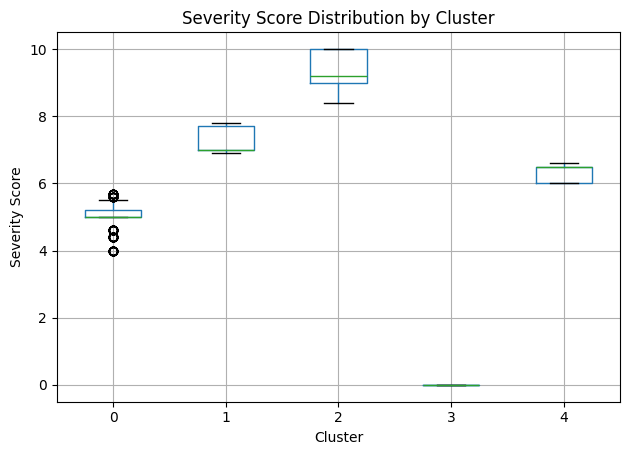

In [33]:
# Plot 1: Severity Score Distribution by Cluster
plt.figure(figsize=(10, 6))
df.boxplot(column='severity_score', by='cluster')
plt.title('Severity Score Distribution by Cluster')
plt.ylabel('Severity Score')
plt.xlabel('Cluster')
plt.suptitle('')
plt.tight_layout()
plt.savefig('severity_by_cluster.png', dpi=300)
plt.show()

<Figure size 1000x600 with 0 Axes>

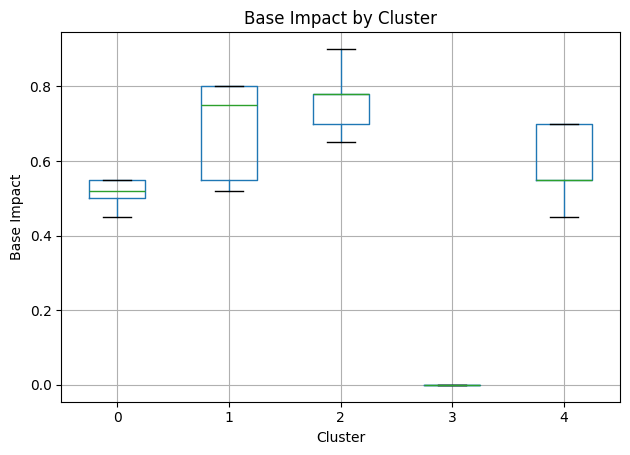

In [34]:
# Plot 2: Base Impact Distribution
plt.figure(figsize=(10, 6))
df.boxplot(column='base_impact', by='cluster')
plt.title('Base Impact by Cluster')
plt.ylabel('Base Impact')
plt.xlabel('Cluster')
plt.suptitle('')
plt.tight_layout()
plt.savefig('impact_by_cluster.png', dpi=300)
plt.show()

In [35]:
# Save the dataframe with cluster assignments for future use
df.to_csv("synthetic_patients_with_clusters.csv", index=False)
print("Saved: synthetic_patients_with_clusters.csv")

Saved: synthetic_patients_with_clusters.csv
